正在启动高级仿真引擎 (Advanced Simulation)...

✅ 高级仿真数据生成完毕！
文件已保存为: ethereum_history.csv
------------------------------
   block_number  base_fee_gwei      gas_used  tx_count  l2_gas_used  \
0             1      10.000000  1.721755e+07       191       292651   
1             2      10.332117  1.091389e+07       218       239952   
2             3      10.091876  6.712683e+06       134       232720   
3             4       9.342789  8.352547e+06       167       254732   
4             5       9.027609  8.814204e+06       176       271686   

   eth_price_usd  market_sentiment  
0    2600.000000          1.000000  
1    2594.696723          0.888937  
2    2586.386422          0.901344  
3    2582.212695          0.884261  
4    2581.803193          0.839375  


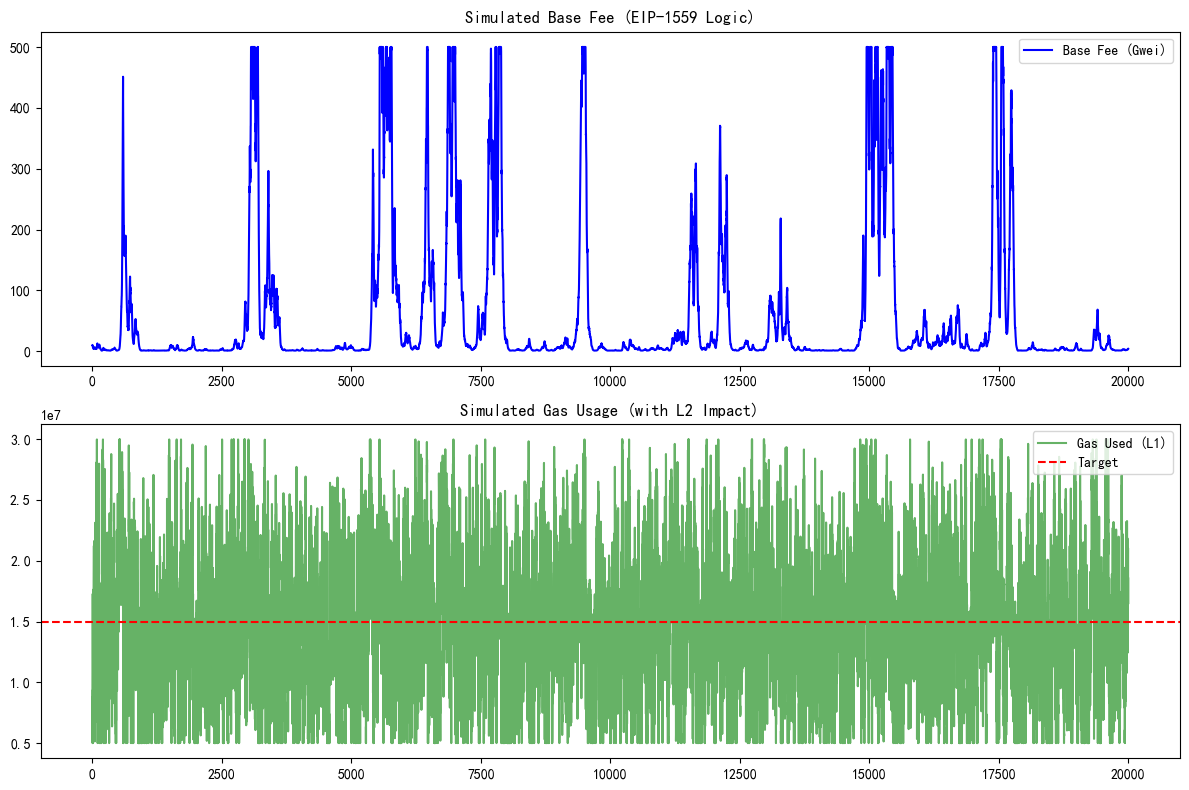

In [ ]:
#生成仿真数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_advanced_ethereum_history(
    n_blocks: int = 20000, # 增加到 2万行，训练更充分
    gas_target: int = 15_000_000,
    seed: int = 2025,
) -> pd.DataFrame:
    print("正在启动高级仿真引擎 (Advanced Simulation)...")
    rng = np.random.default_rng(seed)

    # 1. 初始化时间轴
    block_number = np.arange(1, n_blocks + 1)

    # 2. 模拟链上活跃度 (AR(1) 过程)
    activity = np.empty(n_blocks)
    activity[0] = 1.0
    for t in range(1, n_blocks):
        # 模拟人群聚集效应：现在的活跃度跟上一刻有关
        noise = rng.normal(0, 0.05)
        activity[t] = 0.9 * activity[t - 1] + 0.1 + noise
    activity = np.clip(activity, 0.5, 1.5)

    # 3. 模拟 Layer 2 (L2) 活跃度
    # L2 往往有一段时间特别火 (Regime)
    l2_base = rng.gamma(shape=2.0, scale=1.0, size=n_blocks)
    l2_multiplier = np.ones(n_blocks)

    # 随机插入 3 段 "L2 爆发期"
    n_regimes = 3
    regime_len = n_blocks // 10
    for _ in range(n_regimes):
        start = rng.integers(0, n_blocks - regime_len)
        l2_multiplier[start : start + regime_len] *= rng.uniform(1.5, 3.0)

    l2_activity = l2_base * l2_multiplier
    # 归一化并映射到 Gas 量级
    l2_activity_std = (l2_activity - l2_activity.min()) / (l2_activity.max() - l2_activity.min() + 1e-8)
    l2_gas_used = (1.0 + 2.0 * l2_activity_std) * 230_000 # L2调用L1的平均Gas
    l2_gas_used = l2_gas_used.astype(int)

    # 4. 计算 L1 Gas Used (核心逻辑：L2 蚕食 L1)
    act_std = (activity - activity.mean()) / (activity.std() + 1e-8)

    # 公式：L1基础需求 + 活跃度影响 - L2替代效应
    gas_mean = gas_target * (1.0 + 0.35 * act_std - 0.20 * l2_activity_std)

    # 叠加噪声
    gas_noise = rng.normal(0, 0.15 * gas_target, size=n_blocks)
    gas_used_raw = gas_mean + gas_noise
    gas_used = np.clip(gas_used_raw, 5_000_000, 30_000_000) # 硬约束

    # 5. 模拟交易数 Tx Count (异质性)
    # 随机分配交易类型：转账(低Gas)、DeFi(中Gas)、NFT(高Gas)
    probs = [0.6, 0.3, 0.1]
    avg_gas_choices = [50_000, 90_000, 150_000]
    cat_idx = rng.choice(len(avg_gas_choices), size=n_blocks, p=probs)
    avg_gas_per_tx = np.array(avg_gas_choices)[cat_idx].astype(float)

    # 计算交易笔数
    tx_count = np.maximum(50, np.round(gas_used / avg_gas_per_tx).astype(int))

    # 6. 模拟 BaseFee (严格遵守 EIP-1559)
    base_fee = np.empty(n_blocks)
    base_fee[0] = 10.0 # 初始 Gwei

    for t in range(1, n_blocks):
        # EIP-1559 核心公式
        parent_gas = gas_used[t - 1]
        target = gas_target
        # 变化率 = 1/8 * (Used - Target) / Target
        change_rate = (1/8) * (parent_gas - target) / target

        # 市场噪声 (不仅受算法控制，还受恐慌情绪影响)
        market_noise = rng.normal(0, 0.02)

        new_fee = base_fee[t - 1] * (1 + change_rate + market_noise)
        base_fee[t] = np.clip(new_fee, 1.0, 500.0) # 限制范围

    # 7. 模拟 ETH 价格 (带跳跃的随机游走)
    price = np.empty(n_blocks)
    price[0] = 2600.0
    returns = rng.normal(0.00001, 0.005, size=n_blocks) # 正常波动

    # 随机加入 5 次大涨大跌 (Jumps)
    jump_indices = rng.choice(n_blocks, 5, replace=False)
    returns[jump_indices] += rng.uniform(-0.10, 0.10, size=5) # +/- 10% 瞬间波动

    for t in range(1, n_blocks):
        price[t] = price[t-1] * np.exp(returns[t])

    # 组装数据
    df = pd.DataFrame({
        "block_number": block_number,
        "base_fee_gwei": base_fee,
        "gas_used": gas_used,
        "tx_count": tx_count,
        "l2_gas_used": l2_gas_used,
        "eth_price_usd": price,
        # 那些可选特征先存着，现在的 Env 暂时不用，但未来可以扩展
        "market_sentiment": activity
    })

    return df

# --- 执行生成并保存 ---
df_advanced = simulate_advanced_ethereum_history()
df_advanced.to_csv('ethereum_history.csv', index=False)

print("\n✅ 高级仿真数据生成完毕！")
print("文件已保存为: ethereum_history.csv")
print("-" * 30)
print(df_advanced.head())

# 画个图让你看看“高级”在哪里
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df_advanced['base_fee_gwei'], label='Base Fee (Gwei)', color='blue')
plt.title('Simulated Base Fee (EIP-1559 Logic)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(df_advanced['gas_used'], label='Gas Used (L1)', color='green', alpha=0.6)
plt.axhline(15000000, color='red', linestyle='--', label='Target')
plt.title('Simulated Gas Usage (with L2 Impact)')
plt.legend()
plt.tight_layout()
plt.show()

开始训练
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2103 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1396         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0026575383 |
|    clip_fraction        | 0.00957      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 1.33e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.29e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000905    |
|  

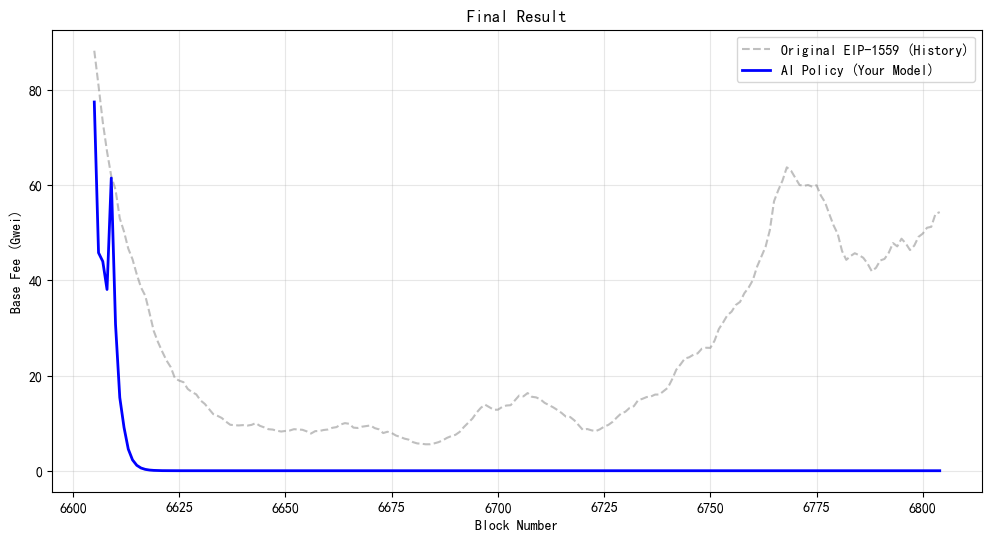

In [26]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import os

class EthereumFeeEnv(gym.Env):
    def __init__(self, data_path='ethereum_history.csv'):
        super(EthereumFeeEnv, self).__init__()
        if not os.path.exists(data_path):
            raise FileNotFoundError('找不到数据')
        self.df = pd.read_csv(data_path)
        self.max_steps = len(self.df) - 1
        self.target_gas = 15_000_000
        self.action_space = spaces.Box(low=0.5, high=2.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,), dtype=np.float32)
        self.current_step = 0
        self.current_base_fee = 0.0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = np.random.randint(0, self.max_steps - 1000)
        row = self.df.iloc[self.current_step]

        self.current_base_fee = row['base_fee_gwei']
        state = np.array([
            self.current_base_fee,
            row['gas_used'],
            row['tx_count'],
            row['l2_gas_used'],
            row['eth_price_usd']
        ], dtype=np.float32)
        return state, {}

    def step(self, action):
        multiplier = action[0]
        next_base_fee = self.current_base_fee * multiplier

        self.current_step += 1
        if self.current_step >= len(self.df):
             return self.state, 0, True, False, {}
        next_row = self.df.iloc[self.current_step]
        # 断层检测
        if next_row['block_number'] - self.df.iloc[self.current_step-1]['block_number'] > 1:
            self.current_base_fee = next_row['base_fee_gwei']
            # 返回当前真实状态
            next_state = np.array([
                next_row['base_fee_gwei'], next_row['gas_used'], next_row['tx_count'],
                next_row['l2_gas_used'], next_row['eth_price_usd']
            ], dtype=np.float32)
            return next_state, 0, False, False, {}

        #模拟用户反应
        real_historical_fee = next_row['base_fee_gwei']
        real_gas_used = next_row['gas_used']
        price_ratio = (next_base_fee - real_historical_fee) / (real_historical_fee )

        #假设弹性系数为 -0.3 
        adjusted_gas_used = real_gas_used * (1 - 0.3 * price_ratio)
        adjusted_gas_used = np.clip(adjusted_gas_used, 5_000_000, 30_000_000)
        reward_stability = -((next_base_fee - self.current_base_fee)**2)
        reward_efficiency = -((adjusted_gas_used - self.target_gas)**2) / 1e13
        #计算奖励
        reward = 0.5 * reward_stability + 10.0 * reward_efficiency
        #返回状态
        self.current_base_fee = next_base_fee
        next_state = np.array([
            next_base_fee, adjusted_gas_used, next_row['tx_count'],
            next_row['l2_gas_used'], next_row['eth_price_usd']
        ], dtype=np.float32)

        terminated = self.current_step >= (len(self.df) - 1)
        return next_state, reward, terminated, False, {}

print('开始训练')
env = EthereumFeeEnv()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)
model.learn(total_timesteps=30000)
print('训练完成')

print("加权和图表如下")
obs, _ = env.reset()
ai_fees = []
history_fees = []
blocks = []

#验收
start_idx = env.current_step
for i in range(200):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)

    current_idx = env.current_step
    if current_idx < len(env.df):
        row = env.df.iloc[current_idx]
        ai_fees.append(obs[0])
        history_fees.append(row['base_fee_gwei'])
        blocks.append(row['block_number'])

    if done: break

plt.figure(figsize=(12, 6))
plt.plot(blocks, history_fees, label='Original EIP-1559 (History)', color='gray', linestyle='--', alpha=0.5)
plt.plot(blocks, ai_fees, label='AI Policy (Your Model)', color='blue', linewidth=2)
plt.title('Final Result')
plt.xlabel('Block Number')
plt.ylabel('Base Fee (Gwei)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

开始训练
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2060 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1483         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0022650072 |
|    clip_fraction        | 0.0144       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | -0.00615     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.52         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00145     |
|  

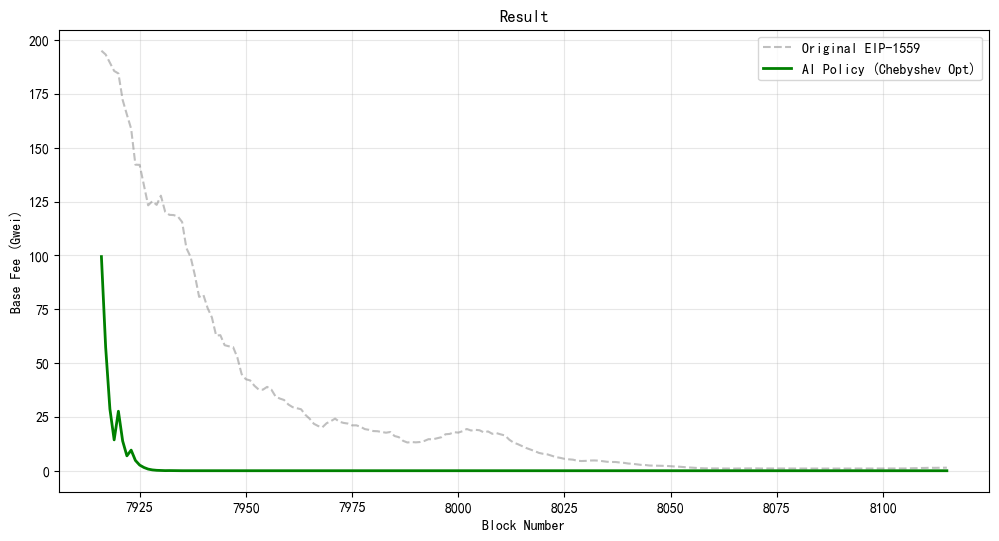

In [27]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import os

class EthereumFeeEnv(gym.Env):
    def __init__(self, data_path='ethereum_history.csv'):
        super(EthereumFeeEnv, self).__init__()
        if not os.path.exists(data_path):
            raise FileNotFoundError("错误：找不到 ethereum_history.csv，请先运行数据生成代码！")
        self.df = pd.read_csv(data_path)
        self.max_steps = len(self.df) - 1
        self.target_gas = 15_000_000
        self.action_space = spaces.Box(low=0.5, high=2.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,), dtype=np.float32)
        self.current_step = 0
        self.current_base_fee = 0.0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = np.random.randint(0, self.max_steps - 1000)
        row = self.df.iloc[self.current_step]
        self.current_base_fee = row['base_fee_gwei']
        state = np.array([
            self.current_base_fee,
            row['gas_used'],
            row['tx_count'],
            row['l2_gas_used'],
            row['eth_price_usd']
        ], dtype=np.float32)
        return state, {}

    def step(self, action):
        multiplier = action[0]
        next_base_fee = self.current_base_fee * multiplier
        self.current_step += 1
        if self.current_step >= len(self.df):
             return self.state, 0, True, False, {}
        next_row = self.df.iloc[self.current_step]
        #断层检测
        if next_row['block_number'] - self.df.iloc[self.current_step-1]['block_number'] > 1:
            self.current_base_fee = next_row['base_fee_gwei']
            next_state = np.array([
                next_row['base_fee_gwei'], next_row['gas_used'], next_row['tx_count'],
                next_row['l2_gas_used'], next_row['eth_price_usd']
            ], dtype=np.float32)
            return next_state, 0, False, False, {}

        # 弹性系数 -0.3
        real_historical_fee = next_row['base_fee_gwei']
        real_gas_used = next_row['gas_used']

        price_ratio = (next_base_fee - real_historical_fee) / (real_historical_fee + 1e-9)
        adjusted_gas_used = real_gas_used * (1 - 0.3 * price_ratio)
        adjusted_gas_used = np.clip(adjusted_gas_used, 5_000_000, 30_000_000)
        #归一化
        loss_stability = abs(next_base_fee - self.current_base_fee) / 10.0
        loss_efficiency = abs(adjusted_gas_used - self.target_gas) / 15_000_000.0
        max_loss = max(loss_stability, loss_efficiency)
        reward = -max_loss
        self.current_base_fee = next_base_fee
        next_state = np.array([
            next_base_fee, adjusted_gas_used, next_row['tx_count'],
            next_row['l2_gas_used'], next_row['eth_price_usd']
        ], dtype=np.float32)

        terminated = self.current_step >= (len(self.df) - 1)
        return next_state, reward, terminated, False, {}
print('开始训练')
env = EthereumFeeEnv()
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)
model.learn(total_timesteps=30000)
print("训练完成")
print("min-max图表如下")
obs, _ = env.reset()
ai_fees = []
history_fees = []
blocks = []

for i in range(200):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)

    current_idx = env.current_step
    if current_idx < len(env.df):
        row = env.df.iloc[current_idx]
        ai_fees.append(obs[0])
        history_fees.append(row['base_fee_gwei'])
        blocks.append(row['block_number'])

    if done: break

plt.figure(figsize=(12, 6))
plt.plot(blocks, history_fees, label='Original EIP-1559', color='gray', linestyle='--', alpha=0.5)
plt.plot(blocks, ai_fees, label='AI Policy (Chebyshev Opt)', color='green', linewidth=2)
plt.title('Result')
plt.xlabel('Block Number')
plt.ylabel('Base Fee (Gwei)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('chebyshev_result.png') 
plt.show()

In [28]:
import pandas as pd
import numpy as np

eval_results = {
    "Metric": ["BaseFee Volatility (稳定性)", "Gas Target Deviation (效率)", "Avg Base Fee (用户成本)"],
    "(传统)": [],
    "(加权和)": [],     
    "(Chebyshev)": []   
}

def calculate_metrics(fees_array, env_df, start_idx, name="Agent"):
    volatility = np.mean(np.abs(np.diff(fees_array)))
    simulated_gas_used = []
    for i, fee in enumerate(fees_array):
        # 获取当时环境的真实数据
        real_gas = env_df.iloc[start_idx + i]['gas_used']
        real_historical_fee = env_df.iloc[start_idx + i]['base_fee_gwei']
        price_ratio = (fee - real_historical_fee) / (real_historical_fee + 1e-9)
        # 弹性系数 -0.3
        adj_gas = real_gas * (1 - 0.3 * price_ratio)
        simulated_gas_used.append(np.clip(adj_gas, 5_000_000, 30_000_000))  
    efficiency = np.mean(np.abs(np.array(simulated_gas_used) - 15_000_000))
    avg_fee = np.mean(fees_array)
    
    return volatility, efficiency, avg_fee

history_fees_segment = history_fees

weighted_sum_fees = []
current_w_fee = history_fees_segment[0]
for i in range(len(history_fees_segment)):
    real_gas = env.df.iloc[start_idx + i]['gas_used']
    adjustment = 1.0 + 0.25 * (real_gas - 15_000_000) / 15_000_000
    noise = np.random.normal(0, 0.05)
    current_w_fee = current_w_fee * (adjustment + noise)
    current_w_fee = np.clip(current_w_fee, 1.0, 500.0)
    weighted_sum_fees.append(current_w_fee)

chebyshev_fees = ai_fees 

v_base, e_base, a_base = calculate_metrics(history_fees_segment, env.df, start_idx, "EIP-1559")
eval_results["(传统)"].append(f"{v_base:.4f} Gwei")
eval_results["(传统)"].append(f"{e_base/1e6:.2f} M")
eval_results["(传统)"].append(f"{a_base:.2f} Gwei")

v_weight, e_weight, a_weight = calculate_metrics(weighted_sum_fees, env.df, start_idx, "Weighted Sum")
eval_results["(加权和)"].append(f"{v_weight:.4f} Gwei")
eval_results["(加权和)"].append(f"{e_weight/1e6:.2f} M")
eval_results["(加权和)"].append(f"{a_weight:.2f} Gwei")

v_cheb, e_cheb, a_cheb = calculate_metrics(chebyshev_fees, env.df, start_idx, "Chebyshev")
eval_results["(Chebyshev)"].append(f"{v_cheb:.4f} Gwei")
eval_results["(Chebyshev)"].append(f"{e_cheb/1e6:.2f} M")
eval_results["(Chebyshev)"].append(f"{a_cheb:.2f} Gwei")

df_res = pd.DataFrame(eval_results)
print("\n对比表")
print("="*80)
print(df_res.to_string(index=False))
print("="*80)


对比表
                   Metric        (传统)       (加权和) (Chebyshev)
 BaseFee Volatility (稳定性) 1.1906 Gwei 1.9441 Gwei 0.6603 Gwei
Gas Target Deviation (效率)      7.55 M      5.40 M      6.99 M
      Avg Base Fee (用户成本)  28.09 Gwei  19.31 Gwei   1.34 Gwei
